In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from grizli import model as griz_model
from scipy.interpolate import interp1d
import os
from glob import glob
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

In [45]:
class Single_spec(object):
    def __init__(self, beam, gal_id,min_wv = 8000, max_wv = 11500):
        BEAM = griz_model.BeamCutout(fits_file= beam)

        self.spec_2D = BEAM.grism.data['SCI']
        self.contam_2D = BEAM.contam
        self.clean_2D = BEAM.grism.data['SCI'] - BEAM.contam
        self.cutout = BEAM.beam.direct*(BEAM.beam.seg == gal_id)
        
        xspec, yspec, yerr = BEAM.beam.optimal_extract(BEAM.grism.data['SCI'], bin=0, ivar=BEAM.ivar) #data
        swv, sens = [BEAM.beam.lam, BEAM.beam.sensitivity / np.max(BEAM.beam.sensitivity)]
        isens = interp1d(swv, sens)(xspec)
        
        IDX= [U for U in range(len(xspec)) if min_wv < xspec[U] < max_wv]
        self.wv = xspec[IDX]
        self.fl = yspec[IDX] / isens[IDX]
        self.er = yerr[IDX] / isens[IDX]

class Stack_spec(object):
    def __init__(self, beam_list, gal_id,min_wv = 7900, max_wv = 11400):
        spec = Single_spec(beam_list[0], gal_id, min_wv = min_wv, max_wv=max_wv)
        
        self.stack_wv = spec.wv[1:-1]
    
        flgrid = np.zeros([len(beam_list), len(self.stack_wv)])
        errgrid = np.zeros([len(beam_list), len(self.stack_wv)])

        # Get wv,fl,er for each spectra
        for i in range(len(beam_list)):
            spec = Single_spec(beam_list[i], gal_id, min_wv = min_wv, max_wv=max_wv)
            flgrid[i] = interp1d(spec.wv, spec.fl)(self.stack_wv)
            errgrid[i] = interp1d(spec.wv, spec.er)(self.stack_wv)
        ################

        flgrid = np.transpose(flgrid)
        errgrid = np.transpose(errgrid)
        weigrid = errgrid ** (-2)
        infmask = np.isinf(weigrid)
        weigrid[infmask] = 0
        ################

        stack, err = np.zeros([2, len(self.stack_wv)])
        for i in range(len(self.stack_wv)):
            stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
            err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
        ################
        
        
        self.stack_fl = np.array(stack)
        self.stack_er = np.array(err)

In [21]:
all_beams = glob('../beams/*41520*')

In [46]:
sp = Stack_spec(all_beams,41520)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.opt

<ErrorbarContainer object of 3 artists>

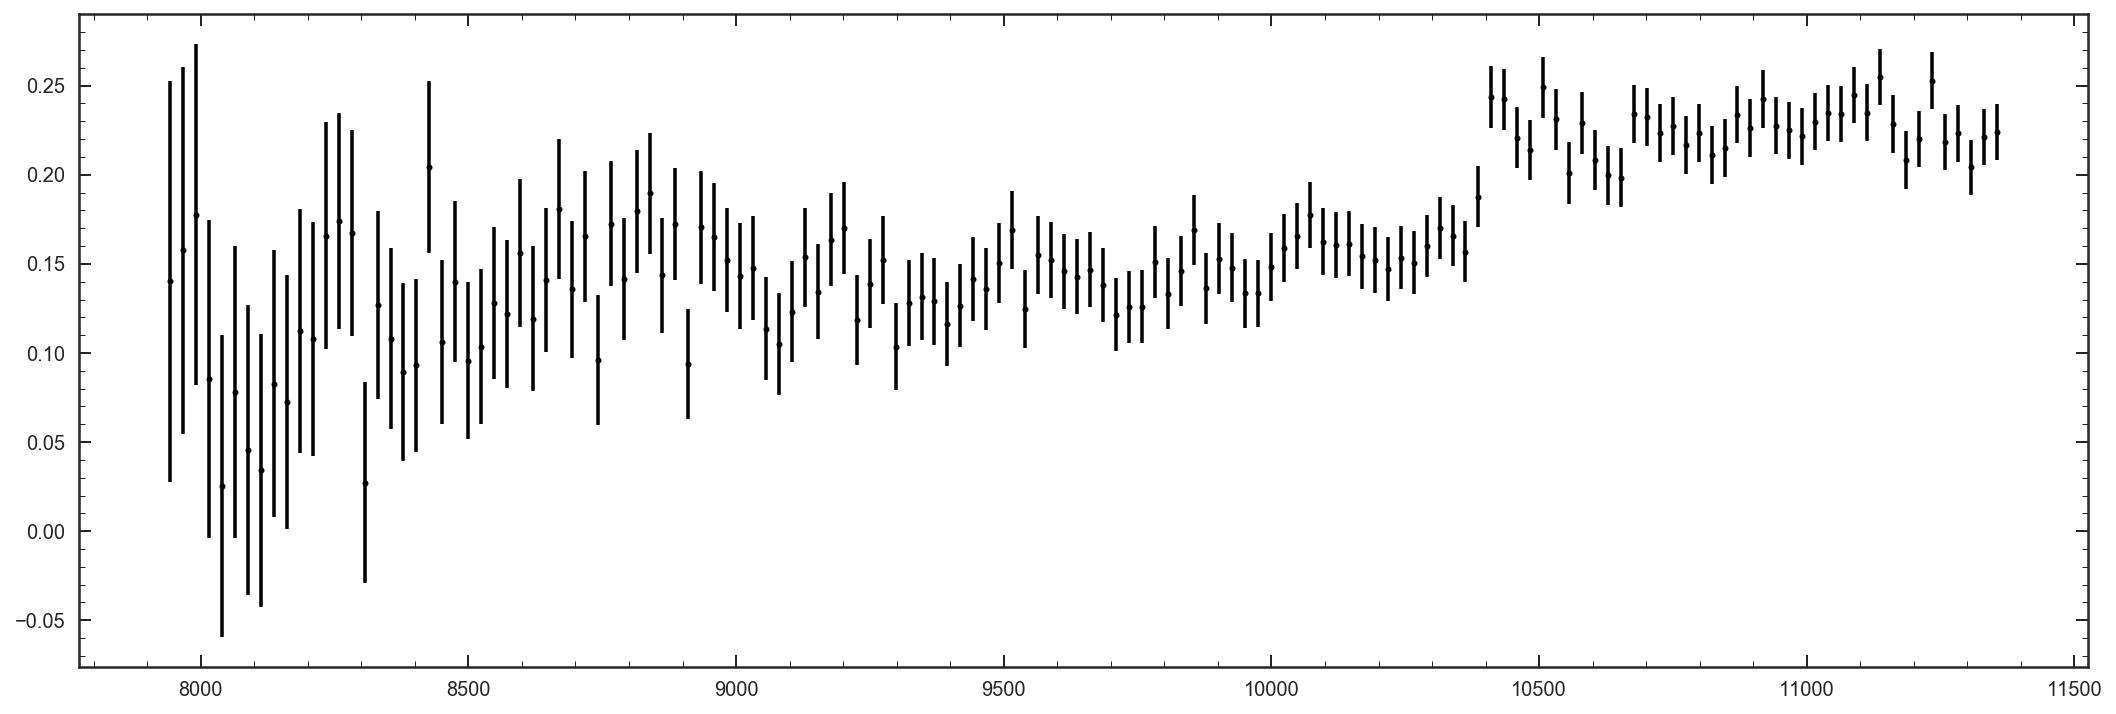

In [49]:
plt.figure(figsize=[18,6])
plt.errorbar(sp.stack_wv, sp.stack_fl, sp.stack_er, linestyle='None', marker='o', markersize=3, color='black')